In [54]:
# !pip install torch torchvision matplotlib opencv-python lxml -q

import os, random, xml.etree.ElementTree as ET
from pathlib import Path
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

In [86]:
# ====== CHANGE THIS to your dataset root ======
DATA_ROOT = Path('C:/Users/thili/OneDrive/Desktop/NumberPlateDetection&Blur')
# We accept either "val" or "valid" for the validation folder name
SPLIT_DIRS = {
    'train': DATA_ROOT/'train',
    'val':   DATA_ROOT/'valid',
    'test':  DATA_ROOT/'test'
}

# Subsampling rules
TRAIN_MAX = 500         # use at most 2000 images for training
TEST_MAX  = 500         # use at most 2000 images for testing
VAL_PCT   = 0.20         # % of TRAIN_MAX for validation (20% of 2000 = 400)
VAL_MAX   = int(TRAIN_MAX * VAL_PCT)

# One class (plus background). Change the name if your XML uses a different one
CLASS_NAMES  = ['License_Plate']
CLASS_TO_ID  = {n:i+1 for i,n in enumerate(CLASS_NAMES)}   # background=0
ID_TO_CLASS  = {v:k for k,v in CLASS_TO_ID.items()}
IMG_EXTS     = {'.jpg','.jpeg','.png','.bmp','.JPG','.PNG'}

TRAIN_DIR = DATA_ROOT/'train'
VAL_DIR   = DATA_ROOT/'valid'
TEST_DIR  = DATA_ROOT/'test'

print("Train dir:", TRAIN_DIR, "exists:", TRAIN_DIR.exists())
print("Val dir  :", VAL_DIR,   "exists:", VAL_DIR.exists())
print("Test dir :", TEST_DIR,  "exists:", TEST_DIR.exists())

print("Using folders:", {k:str(v) for k,v in SPLIT_DIRS.items()})
print("Max train:", TRAIN_MAX, " Max val:", VAL_MAX, " Max test:", TEST_MAX)


Train dir: C:\Users\thili\OneDrive\Desktop\NumberPlateDetection&Blur\train exists: True
Val dir  : C:\Users\thili\OneDrive\Desktop\NumberPlateDetection&Blur\valid exists: True
Test dir : C:\Users\thili\OneDrive\Desktop\NumberPlateDetection&Blur\test exists: True
Using folders: {'train': 'C:\\Users\\thili\\OneDrive\\Desktop\\NumberPlateDetection&Blur\\train', 'val': 'C:\\Users\\thili\\OneDrive\\Desktop\\NumberPlateDetection&Blur\\valid', 'test': 'C:\\Users\\thili\\OneDrive\\Desktop\\NumberPlateDetection&Blur\\test'}
Max train: 500  Max val: 100  Max test: 500


In [87]:
def list_pairs(folder: Path):
    """Return list of (image_path, xml_path) pairs where both exist and share the same stem."""
    files = list(folder.glob('*'))
    stems_img = {p.stem for p in files if p.suffix in IMG_EXTS}
    stems_xml = {p.stem for p in files if p.suffix.lower()=='.xml'}
    stems = sorted(stems_img & stems_xml)
    pairs = []
    for s in stems:
        # find the actual image file with this stem
        img = None
        for ext in IMG_EXTS:
            p = folder / f"{s}{ext}"
            if p.exists():
                img = p; break
        if img is None: continue
        xml = folder / f"{s}.xml"
        if xml.exists():
            pairs.append((img, xml))
    return pairs

def subsample_pairs(pairs, k, seed=SEED):
    if k is None or k <= 0 or k >= len(pairs): 
        return pairs
    random.Random(seed).shuffle(pairs)
    return pairs[:k]

pairs_train = list_pairs(SPLIT_DIRS['train'])
pairs_val   = list_pairs(SPLIT_DIRS['val'])
pairs_test  = list_pairs(SPLIT_DIRS['test'])

pairs_train = subsample_pairs(pairs_train, TRAIN_MAX)
pairs_val   = subsample_pairs(pairs_val,   VAL_MAX)
pairs_test  = subsample_pairs(pairs_test,  TEST_MAX)

print(f"Found  train: {len(pairs_train)}  val: {len(pairs_val)}  test: {len(pairs_test)}")
print("Example train pair:", pairs_train[0] if pairs_train else "NONE")


Found  train: 500  val: 100  test: 500
Example train pair: (WindowsPath('C:/Users/thili/OneDrive/Desktop/NumberPlateDetection&Blur/train/CarLongPlateGen421_jpg.rf.2ae8bffd3c75429cf2cb3f2a57130e7c.jpg'), WindowsPath('C:/Users/thili/OneDrive/Desktop/NumberPlateDetection&Blur/train/CarLongPlateGen421_jpg.rf.2ae8bffd3c75429cf2cb3f2a57130e7c.xml'))


In [88]:
CLASS_NAMES = ['License_Plate']
CLASS_TO_ID = {n:i+1 for i,n in enumerate(CLASS_NAMES)}  # bg=0
ID_TO_CLASS = {v:k for k,v in CLASS_TO_ID.items()}

def parse_voc_xml(xml_path):
    root = ET.parse(str(xml_path)).getroot()
    size = root.find('size')
    W = int(size.find('width').text)
    H = int(size.find('height').text)

    boxes, labels = [], []
    for obj in root.findall('object'):
        name = obj.find('name').text.strip()
        if name not in CLASS_TO_ID:
            continue
        b = obj.find('bndbox')
        xmin = float(b.find('xmin').text); ymin = float(b.find('ymin').text)
        xmax = float(b.find('xmax').text); ymax = float(b.find('ymax').text)
        xmin, xmax = max(0,xmin), min(W-1,xmax)
        ymin, ymax = max(0,ymin), min(H-1,ymax)
        if xmax > xmin and ymax > ymin:
            boxes.append([xmin,ymin,xmax,ymax])
            labels.append(CLASS_TO_ID[name])

    # ensure shapes: (0,4) for empty, (N,) for labels
    if len(boxes) == 0:
        boxes_np  = np.zeros((0,4), dtype=np.float32)
        labels_np = np.zeros((0,),  dtype=np.int64)
    else:
        boxes_np  = np.array(boxes,  dtype=np.float32)
        labels_np = np.array(labels, dtype=np.int64)

    return boxes_np, labels_np

class VOCDataset(Dataset):
    def __init__(self, pairs, resize_to=640, augment=False):
        self.pairs = pairs
        self.resize_to = resize_to
        self.augment = augment

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, xml_path = self.pairs[idx]
        try:
            # Check file existence
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file missing: {img_path}")
            if not os.path.exists(xml_path):
                raise FileNotFoundError(f"Annotation missing: {xml_path}")

            img = cv2.imread(str(img_path))
            if img is None:
                raise ValueError(f"Image could not be loaded: {img_path}")

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            H, W = img.shape[:2]

            boxes, labels = parse_voc_xml(xml_path)

            # Resize
            if self.resize_to is not None:
                new = int(self.resize_to)
                sx, sy = new / W, new / H
                img = cv2.resize(img, (new, new), interpolation=cv2.INTER_LINEAR)
                if len(boxes):
                    boxes = boxes.copy()
                    boxes[:, [0, 2]] *= sx
                    boxes[:, [1, 3]] *= sy
                W = H = new

            # Augmentation: horizontal flip
            import random
            if self.augment and random.random() < 0.5:
                img = np.ascontiguousarray(img[:, ::-1, :])
                if len(boxes):
                    x1 = W - boxes[:, 2]
                    x2 = W - boxes[:, 0]
                    boxes[:, 0], boxes[:, 2] = x1, x2

            boxes_t  = torch.as_tensor(boxes,  dtype=torch.float32)
            labels_t = torch.as_tensor(labels, dtype=torch.int64)

            if boxes_t.numel() > 0:
                area = (boxes_t[:, 2] - boxes_t[:, 0]) * (boxes_t[:, 3] - boxes_t[:, 1])
            else:
                area = torch.zeros((0,), dtype=torch.float32)

            target = {
                'boxes':   boxes_t,
                'labels':  labels_t,
                'image_id': torch.tensor([idx]),
                'area':     area,
                'iscrowd':  torch.zeros((len(boxes_t),), dtype=torch.int64)
            }

            img_t = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
            return img_t, target, str(img_path)

        except Exception as e:
            print(f"❌ Skipping sample {img_path}: {e}")
            # Return an empty valid structure so DataLoader won't break
            empty_img = torch.zeros((3, self.resize_to, self.resize_to), dtype=torch.float32)
            empty_target = {
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'labels': torch.zeros((0,), dtype=torch.int64),
                'image_id': torch.tensor([idx]),
                'area': torch.zeros((0,), dtype=torch.float32),
                'iscrowd': torch.zeros((0,), dtype=torch.int64)
            }
            return empty_img, empty_target, str(img_path)
        
def collate_fn(batch):
    imgs, targets, paths = list(zip(*batch))
    return list(imgs), list(targets), list(paths)        


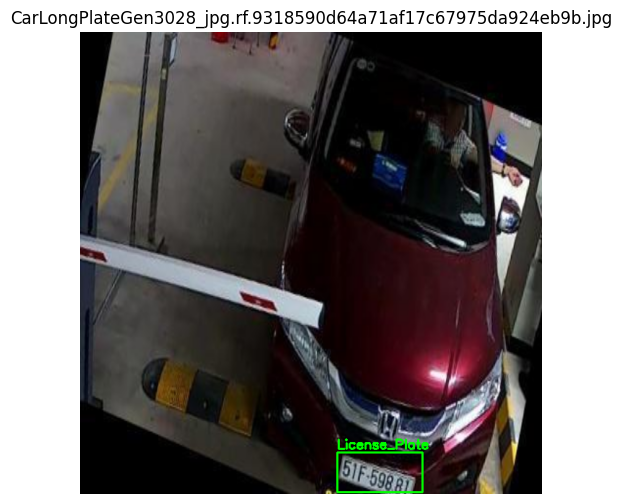

In [91]:
def show_sample(ds, i=None):
    if len(ds)==0: 
        print("Dataset empty"); return
    if i is None: i = random.randrange(len(ds))
    img_t, tgt, path = ds[i]
    img = (img_t.permute(1,2,0).numpy()*255).astype(np.uint8).copy()
    for (x1,y1,x2,y2), lab in zip(tgt['boxes'].numpy(), tgt['labels'].numpy()):
        cv2.rectangle(img, (int(x1),int(y1)), (int(x2),int(y2)), (0,255,0), 2)
        cv2.putText(img, f"{ID_TO_CLASS[int(lab)]}", (int(x1),max(0,int(y1)-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
    plt.figure(figsize=(6,6)); plt.imshow(img); plt.title(Path(path).name); plt.axis('off')

train_ds = VOCDataset(pairs_train, resize_to=640, augment=True)
val_ds   = VOCDataset(pairs_val,   resize_to=640, augment=False)
test_ds  = VOCDataset(pairs_test,  resize_to=640, augment=False)

show_sample(train_ds)


In [92]:
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True,  num_workers=0, collate_fn=collate_fn, pin_memory=True, drop_last=True)
val_dl   = DataLoader(val_ds,   batch_size=4, shuffle=False, num_workers=0, collate_fn=collate_fn, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=4, shuffle=False, num_workers=0, collate_fn=collate_fn, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)


(500, 100, 500)

In [93]:
def get_model(num_classes: int):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
    in_feats = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, num_classes)  # bg + classes
    return model

num_classes = 1 + len(CLASS_NAMES)  # background + License_Plate
model = get_model(num_classes).to(device)


In [94]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_sched  = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

def train_one_epoch(model, loader):
    model.train()
    running = 0.0
    total_batches = len(loader)

    for batch_idx, batch in enumerate(loader, start=1):
        try:
            imgs, tgts, _ = batch
        except Exception as e:
            print(f"[Batch {batch_idx}] ❌ Skipped due to error loading data: {e}")
            continue

        try:
            imgs = [img.to(device) for img in imgs]
            tgts = [{k: v.to(device) for k, v in t.items()} for t in tgts]

            loss_dict = model(imgs, tgts)
            loss = sum(v for v in loss_dict.values())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running += float(loss.item())

            if batch_idx % 10 == 0 or batch_idx == total_batches:
                print(f"[Batch {batch_idx}/{total_batches}] "
                      f"Loss: {loss.item():.4f} | Running avg: {running / batch_idx:.4f}")
        except Exception as e:
            print(f"[Batch {batch_idx}] ❌ Skipped during training step: {e}")
            continue

    return running / max(1, total_batches)



@torch.no_grad()
def evaluate_prf1(model, loader, iou_thr=0.5, conf_thr=0.5):
    model.eval()
    tp=fp=fn=0
    for imgs, tgts, _ in loader:
        outs = model([img.to(device) for img in imgs])
        for out, tgt in zip(outs, tgts):
            gt = tgt['boxes'].numpy()
            pred_boxes = out['boxes'].cpu().numpy()
            scores     = out['scores'].cpu().numpy()
            keep = scores >= conf_thr
            pred_boxes = pred_boxes[keep]

            used = set()
            for pb in pred_boxes:
                best_iou, best_j = 0.0, -1
                for j, gb in enumerate(gt):
                    xx1=max(pb[0],gb[0]); yy1=max(pb[1],gb[1])
                    xx2=min(pb[2],gb[2]); yy2=min(pb[3],gb[3])
                    inter = max(0,xx2-xx1)*max(0,yy2-yy1)
                    ap = max(1e-6,(pb[2]-pb[0])*(pb[3]-pb[1]))
                    ag = max(1e-6,(gb[2]-gb[0])*(gb[3]-gb[1]))
                    iou = inter/(ap+ag-inter+1e-6)
                    if iou>best_iou:
                        best_iou, best_j = iou, j
                if best_iou>=iou_thr and best_j not in used:
                    tp+=1; used.add(best_j)
                else:
                    fp+=1
            fn += max(0, len(gt)-len(used))
    P = tp/(tp+fp+1e-9); R = tp/(tp+fn+1e-9); F1 = 2*P*R/(P+R+1e-9)
    return {'precision':P,'recall':R,'f1':F1,'tp':tp,'fp':fp,'fn':fn}

EPOCHS = 1  # increase if you can
best_f1, best_path = 0.0, None
for epoch in range(1, EPOCHS+1):
    tr = train_one_epoch(model, train_dl)
    val = evaluate_prf1(model, val_dl, iou_thr=0.5, conf_thr=0.5)
    lr_sched.step()
    print(f"Epoch {epoch:02d} | train loss {tr:.3f} | "
          f"val P/R/F1 {val['precision']:.3f}/{val['recall']:.3f}/{val['f1']:.3f} "
          f"(tp={val['tp']}, fp={val['fp']}, fn={val['fn']})")
    if val['f1'] > best_f1:
        best_f1 = val['f1']
        best_path = '/content/best_frcnn_lp.pth'
        torch.save(model.state_dict(), best_path)

print("Best val F1:", round(best_f1,4), "saved:", best_path)


[Batch 10/125] Loss: 0.3169 | Running avg: 0.3879
[Batch 20/125] Loss: 0.1799 | Running avg: 0.3182
[Batch 30/125] Loss: 0.1670 | Running avg: 0.2696
[Batch 40/125] Loss: 0.1918 | Running avg: 0.2469
[Batch 50/125] Loss: 0.1517 | Running avg: 0.2281
[Batch 60/125] Loss: 0.1364 | Running avg: 0.2113
[Batch 70/125] Loss: 0.1346 | Running avg: 0.1972
[Batch 80/125] Loss: 0.0961 | Running avg: 0.1866
[Batch 90/125] Loss: 0.0633 | Running avg: 0.1762
[Batch 100/125] Loss: 0.1092 | Running avg: 0.1695
[Batch 110/125] Loss: 0.1637 | Running avg: 0.1621
[Batch 120/125] Loss: 0.0927 | Running avg: 0.1559
[Batch 125/125] Loss: 0.0827 | Running avg: 0.1560
Epoch 01 | train loss 0.156 | val P/R/F1 0.737/0.883/0.803 (tp=98, fp=35, fn=13)


RuntimeError: Parent directory /content does not exist.

Sample 1: C:\Users\thili\OneDrive\Desktop\NumberPlateDetection&Blur\valid\CarLongPlateGen3583_jpg.rf.767b580fe406c32492ef198f05cc28a7.jpg
  Image shape: torch.Size([3, 640, 640])
  Boxes: tensor([[214.2373, 221.7822, 371.5254, 337.9538]])
  Labels: tensor([1])
  Number of boxes: 1
----------------------------------------
Sample 2: C:\Users\thili\OneDrive\Desktop\NumberPlateDetection&Blur\valid\CarLongPlateGen3611_jpg.rf.97070e4f68f5fcc84857bb05d580bfcb.jpg
  Image shape: torch.Size([3, 640, 640])
  Boxes: tensor([[309.1526, 454.1254, 436.6102, 572.4092]])
  Labels: tensor([1])
  Number of boxes: 1
----------------------------------------
Sample 3: C:\Users\thili\OneDrive\Desktop\NumberPlateDetection&Blur\valid\CarLongPlateGen3067_jpg.rf.4e0286eeb1e91bc6093d75da84b49a55.jpg
  Image shape: torch.Size([3, 640, 640])
  Boxes: tensor([[288.8136, 283.0363, 425.7627, 397.0957]])
  Labels: tensor([1])
  Number of boxes: 1
----------------------------------------
Sample 4: C:\Users\thili\OneDri

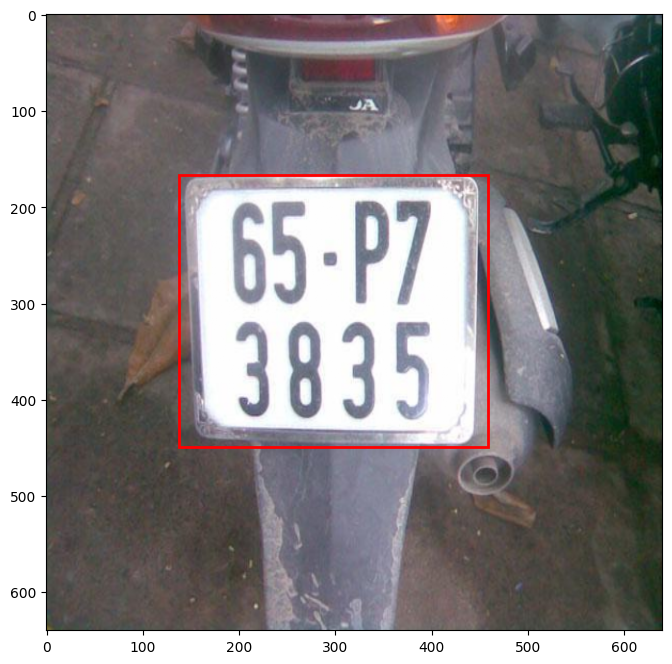

In [69]:
# Check first few samples in the validation dataset
for i in range(5):
    img, target, path = val_ds[i]
    print(f"Sample {i+1}: {path}")
    print(f"  Image shape: {img.shape}")
    print(f"  Boxes: {target['boxes']}")
    print(f"  Labels: {target['labels']}")
    print(f"  Number of boxes: {len(target['boxes'])}")
    print("-"*40)

# Optionally, visualize the first image with boxes
import matplotlib.pyplot as plt
import matplotlib.patches as patches

img_np = img.permute(1,2,0).numpy()
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.imshow(img_np)

for box in target['boxes']:
    x1, y1, x2, y2 = box
    rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()


In [70]:
xml_path = val_ds.pairs[0][1]  # first XML path
boxes, labels = parse_voc_xml(xml_path)
print("Boxes:", boxes)
print("Labels:", labels)


Boxes: [[158. 105. 274. 160.]]
Labels: [1]
